In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.utils import shuffle
import time
import scipy.io
%matplotlib inline

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

def tanh_prime(x):
    return 1 - np.tanh(x)**2

def relu_prime(x):
    return np.where(x > 0, 1, 0)

In [3]:
class QuadraticCost(object):
    @staticmethod
    def fn(a, y):
        return 0.5 * np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):
        return (a-y) * tanh_prime(z)
    
class CrossEntropyCost(object):
    @staticmethod
    def fn(a, y):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
    
    @staticmethod
    def delta(z, a, y):
        return (a-y)
    
class Sigmoid(object):
    @staticmethod
    def activate(z):
        return 1.0/(1.0+np.exp(-z))
    
    @staticmethod
    def delta(z):
        return sigmoid(z)*(1-sigmoid(z))
    
class Tanh(object):
    @staticmethod
    def activate(z):
        return np.tanh(z)
    
    @staticmethod
    def delta(z):
        return 1.0 - np.tanh(z)**2
    
class ReLU(object):
    @staticmethod
    def activate(z):
        return np.maximum(0, z)
    
    @staticmethod
    def delta(z):
        return np.where(z > 0, 1, 0)
    
class Network(object):
    def __init__(self, sizes, cost=CrossEntropyCost, func=Sigmoid):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.weight_initializer()
        self.cost=cost
        self.func=func

    def weight_initializer(self):
        self.weights = [np.random.randn(y, x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = (self.func).activate(np.dot(w, a)+b)
        return a
    
    def train(self, training_data, epochs, learning_rate, save=False):
        n = len(training_data)
        log_file = open("log.txt", "w")  # records loss for each epoch
        log_file.write("Number of epochs: %d, Learning rate: %f\n" % (epochs, learning_rate))
    
        # perform gradient check using numerical approximation
        # self.gradient_check(training_data)

        # Initialize a list to store loss for each epoch
        losses = []
    
        for j in range(epochs):
            error_b = [np.zeros(b.shape) for b in self.biases]
            error_w = [np.zeros(w.shape) for w in self.weights]
            for (x, y) in training_data:
                delta_error_b, delta_error_w = self.backprop(x, y)
                error_b = [(eb+deb/n) for eb, deb in zip(error_b, delta_error_b)]
                error_w = [(ew+dew/n) for ew, dew in zip(error_w, delta_error_w)]
    
            loss = self.loss(training_data)
            log_file.write("Epoch %d: %f\n" % (j, loss))
            log_file.flush()  # Flush the file to disk after writing each line
            losses.append(loss)
    
            self.weights = [w-learning_rate*ew for w, ew in zip(self.weights, error_w)]
            self.biases = [b-learning_rate*eb for b, eb in zip(self.biases, error_b)]                
    
        log_file.close()

        if save:
            self.save("model.txt")

    def backprop(self, x, y):
        error_b = [np.zeros(b.shape) for b in self.biases]
        error_w = [np.zeros(w.shape) for w in self.weights]
        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = (self.func).activate(z)
            activations.append(activation)
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        error_w[-1] = np.dot(delta, activations[-2].transpose())
        error_b[-1] = delta
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = (self.func).delta(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            error_w[-l] = np.dot(delta, activations[-l-1].transpose())
            error_b[-l] = delta
        return (error_b, error_w)
    
    def loss(self, data):
        loss = 0
        for x, y in data:
            a = self.feedforward(x)
            # if convert: y = vectorized_result(y)
            loss += self.cost.fn(a, y)/len(data)
        return loss
    
    def save(self, filename):
        # save with the following format: sizes, weights, biases, cost, func line by line
        with open(filename, "w") as f:
            f.write("%s\n" % self.sizes)
            for w in self.weights:
                for row in w:
                    f.write("%s\n" % row)
            for b in self.biases:
                for row in b:
                    f.write("%s\n" % row)
            f.write("%s\n" % self.cost)
            f.write("%s\n" % self.func)
        f.close()

    def test(self, test_data, error=False):
        # print(self.feedforward(test_data[0][0]))
        test_results = [(1 if self.feedforward(x) > 0 else -1, y) for (x, y) in test_data]
        accuracy = np.mean([int(x == y) for (x, y) in test_results])
        # print("Accuracy: ", accuracy)
        # print(test_results)
        if error:
            return 1 - accuracy
        return accuracy

    
    def gradient_check(self, training_data):
        epsilon = 1e-7
        tolerance = 1e-3
        
        for x, y in training_data:
            backprop_b, backprop_w = self.backprop(x, y)

            for i in range(len(self.biases)):
                for j in range(len(self.biases[i])):
                    original_bias = self.biases[i][j]
                    self.biases[i][j] += epsilon
                    loss_plus = self.loss([(x, y)])
                    self.biases[i][j] -= 2*epsilon
                    loss_minus = self.loss([(x, y)])
                    self.biases[i][j] = original_bias
                    numerical_gradient = (loss_plus - loss_minus) / (2*epsilon)

                    if abs(numerical_gradient - backprop_b[i][j]) > tolerance:
                        print("Gradient check failed for bias[%d][%d]: %f vs %f" % (i, j, numerical_gradient, backprop_b[i][j]))

            for i in range(len(self.weights)):
                for j in range(len(self.weights[i])):
                    for k in range(len(self.weights[i][j])):
                        original_weight = self.weights[i][j][k]
                        self.weights[i][j][k] += epsilon
                        loss_plus = self.loss([(x, y)])
                        self.weights[i][j][k] -= 2*epsilon
                        loss_minus = self.loss([(x, y)])
                        self.weights[i][j][k] = original_weight
                        numerical_gradient = (loss_plus - loss_minus) / (2*epsilon)

                        if abs(numerical_gradient - backprop_w[i][j][k]) > tolerance:
                            print("Gradient check failed for weight[%d][%d][%d]: %f vs %f" % (i, j, k, numerical_gradient, backprop_w[i][j][k]))

def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [4]:
def load_network():
    file = open("network.txt", "r")
    # format: sizes, cost function, activation function each on a separate line 
    sizes = list(map(int, file.readline().split()))

    # Read the cost function and activation function names
    cost_fn_name = file.readline().strip()
    activation_fn_name = file.readline().strip()

    # Mapping of cost function names to classes
    cost_fn_mapping = {
        "QuadraticCost": QuadraticCost,
        "CrossEntropyCost": CrossEntropyCost
    }

    # Mapping of activation function names to classes
    activation_fn_mapping = {
        "Sigmoid": Sigmoid,
        "Tanh": Tanh
    }

    # Get the actual classes based on the names read from the file
    cost_fn = cost_fn_mapping.get(cost_fn_name, CrossEntropyCost)  # Default to CrossEntropyCost if not found
    activation_fn = activation_fn_mapping.get(activation_fn_name, Sigmoid)  # Default to Sigmoid if not found

    # Initialize the network with the correct classes
    net = Network(sizes, cost=cost_fn, func=activation_fn)
    print(sizes, cost_fn_name, activation_fn_name)
    return net

## Use benchmark datasets to test the algorithm

In [5]:
scipy.io.loadmat('benchmarks_v6.mat')

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Fri Mar 11 00:10:10 2005',
 '__version__': '1.0',
 '__globals__': [],
 'banana': array([[(array([[-3.0898387 , -0.83168647],
                [-2.9808342 , -0.15957534],
                [-2.8360574 , -0.17708113],
                ...,
                [ 2.7103145 ,  1.3465977 ],
                [ 2.7544469 ,  1.4719528 ],
                [ 2.8133603 ,  1.3016674 ]]), array([[-1],
                [-1],
                [-1],
                ...,
                [ 1],
                [ 1],
                [ 1]], dtype=int16), array([[4524,  369,  859, ..., 3448,  318, 5065],
                [4648, 1717, 4011, ...,  792, 2899, 1921],
                [5012, 4745,  788, ..., 2464,  519, 3667],
                ...,
                [2680,  793,  869, ..., 4911, 3784, 4202],
                [3620, 1157,  527, ...,   36, 1463, 3359],
                [1907, 3252, 4700, ..., 4266, 4601, 3056]]), array([[3800, 3017,  475, ..., 5295, 

# Start off with the Breast Cancer dataset

In [6]:
mat = scipy.io.loadmat('benchmarks_v6.mat')
ringnorm_dataset_X = mat["ringnorm"]['x'][0, 0]
ringnorm_dataset_y = mat["ringnorm"]['t'][0, 0]
ringnorm_dataset_test = mat["ringnorm"]['test'][0, 0]
ringnorm_dataset_train = mat["ringnorm"]['train'][0, 0]

In [7]:
# convert the -1 values to 0
# ringnorm_dataset_y = np.where(ringnorm_dataset_y == -1, 0, ringnorm_dataset_y)

ringnorm_X_train = ringnorm_dataset_X[ringnorm_dataset_train[0]-1]
ringnorm_y_train = ringnorm_dataset_y[ringnorm_dataset_train[0]-1]
ringnorm_training_inputs = [np.reshape(x, (len(x), 1)) for x in ringnorm_X_train]
ringnorm_training_results = [np.reshape(y, (1, 1)) for y in ringnorm_y_train]
ringnorm_training_data = list(zip(ringnorm_training_inputs, ringnorm_training_results))

ringnorm_X_test = ringnorm_dataset_X[ringnorm_dataset_test[0]-1]
ringnorm_y_test = ringnorm_dataset_y[ringnorm_dataset_test[0]-1]
ringnorm_test_inputs = [np.reshape(x, (len(x), 1)) for x in ringnorm_X_test]
ringnorm_test_results = [np.reshape(y, (1, 1)) for y in ringnorm_y_test]
ringnorm_test_data = list(zip(ringnorm_test_inputs, ringnorm_test_results))

In [74]:
net = load_network()

[20, 40, 1] QuadraticCost Tanh


In [75]:
net.train(ringnorm_training_data, 500, 0.2)

In [76]:
Network.test(net, ringnorm_test_data)

Accuracy:  0.7025714285714286


0.7025714285714286

0.2611428571428571
Elapsed time:  2.828125


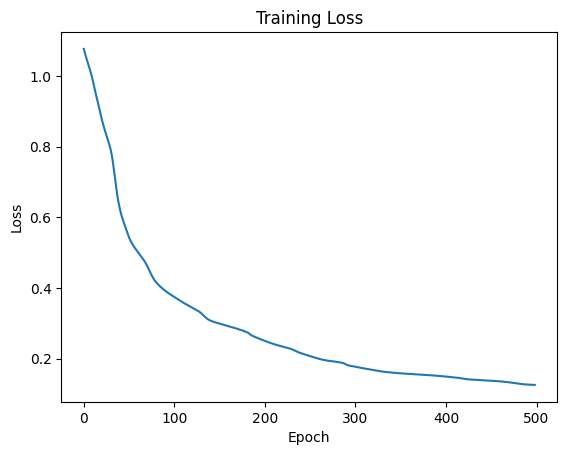

0.20814285714285718
Elapsed time:  3.34375


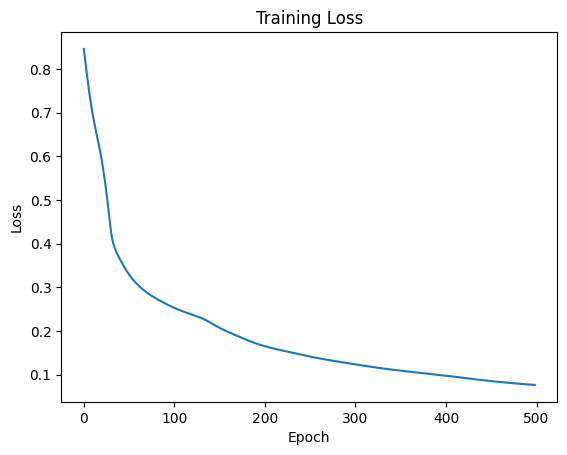

0.20314285714285718
Elapsed time:  0.40625


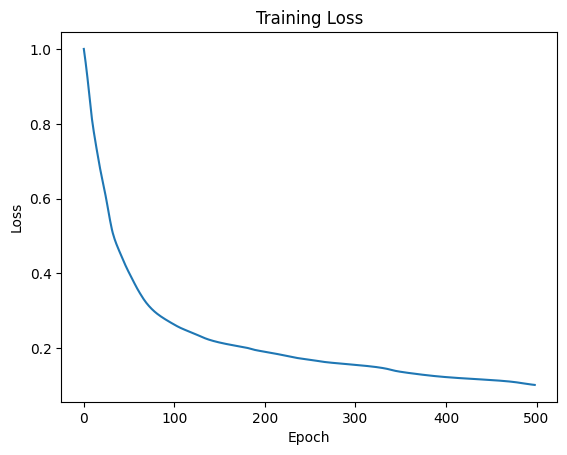

0.20014285714285718
Elapsed time:  0.890625


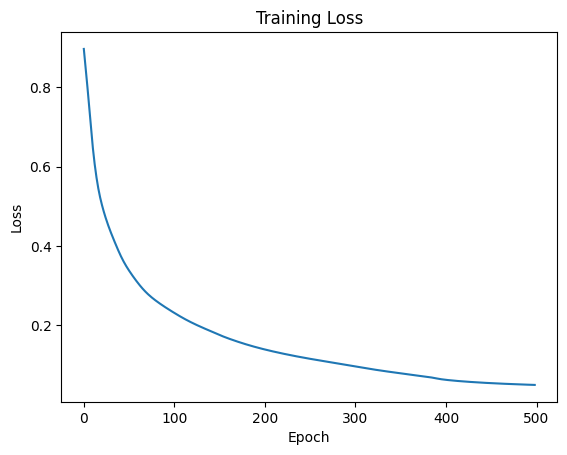

0.21657142857142853
Elapsed time:  2.71875


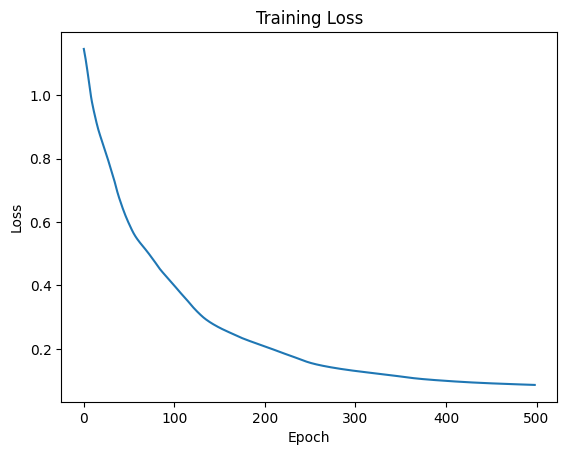

0.20214285714285718
Elapsed time:  3.9375


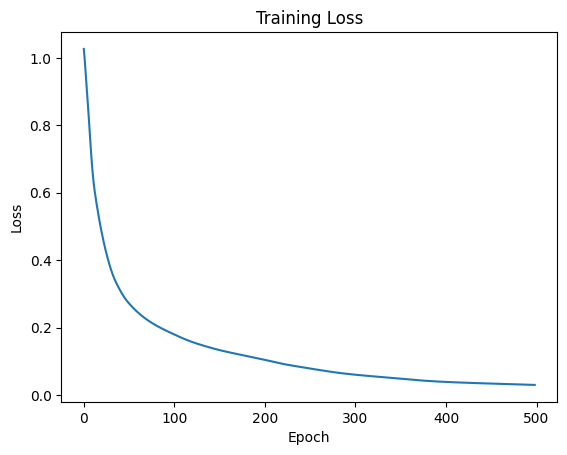

0.21185714285714285
Elapsed time:  4.296875


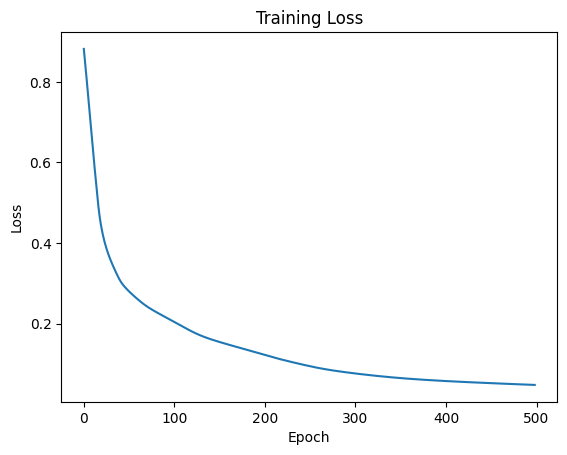

0.23257142857142854
Elapsed time:  3.921875


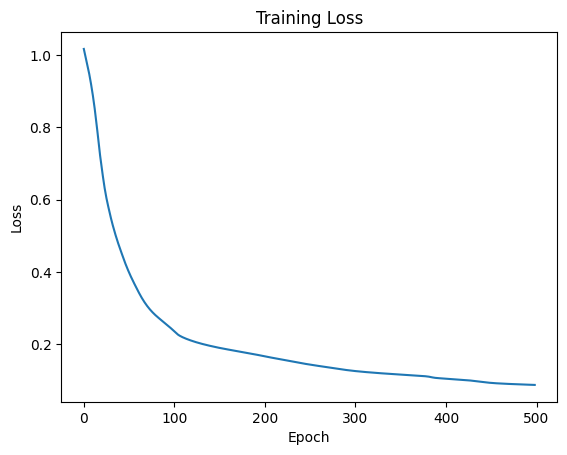

0.25
Elapsed time:  5.1875


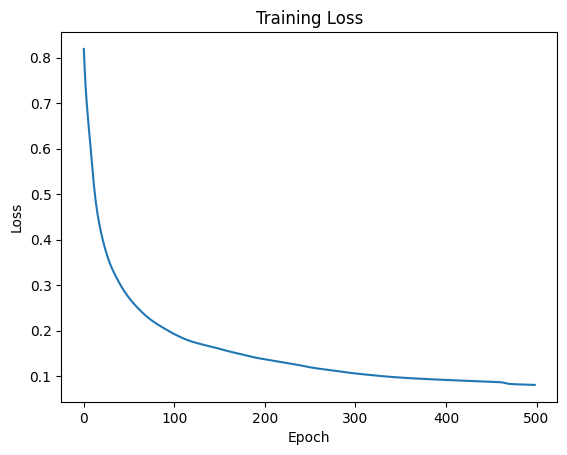

0.23199999999999998
Elapsed time:  6.25


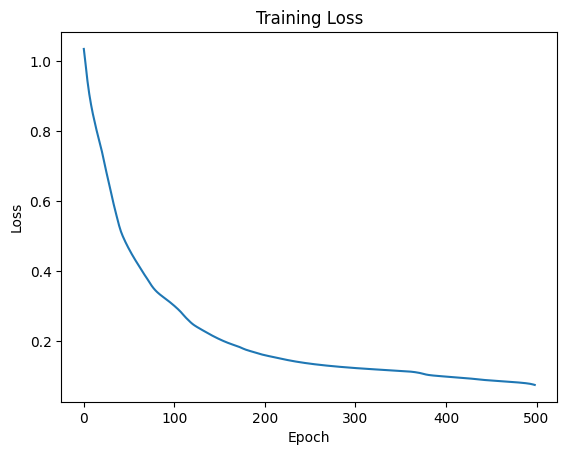

Average test error:  0.2217714285714286 +- 0.02019751449651006


In [25]:
# Output average test error +- standard deviation for 10 runs each having 400 training samples and all having same proportion of 1 and -1
from sklearn.utils import shuffle
import time

test_errors = []
c = 0

while True:
    # pick a randon number between 0 to 99
    a = random.randint(0, 99)

    ringnorm_X_train = ringnorm_dataset_X[ringnorm_dataset_train[a]-1]
    ringnorm_y_train = ringnorm_dataset_y[ringnorm_dataset_train[a]-1]
    ringnorm_training_inputs = [np.reshape(x, (len(x), 1)) for x in ringnorm_X_train]
    ringnorm_training_results = [np.reshape(y, (1, 1)) for y in ringnorm_y_train]
    ringnorm_training_data = list(zip(ringnorm_training_inputs, ringnorm_training_results))

    ringnorm_X_test = ringnorm_dataset_X[ringnorm_dataset_test[a]-1]
    ringnorm_y_test = ringnorm_dataset_y[ringnorm_dataset_test[a]-1]
    ringnorm_test_inputs = [np.reshape(x, (len(x), 1)) for x in ringnorm_X_test]
    ringnorm_test_results = [np.reshape(y, (1, 1)) for y in ringnorm_y_test]
    ringnorm_test_data = list(zip(ringnorm_test_inputs, ringnorm_test_results))

    net = Network([20, 16, 1], cost=QuadraticCost, func=Tanh)
    # note train time
    start_time = time.process_time()
    net.train(ringnorm_training_data, 500, 0.4)
    end_time = time.process_time()
    elapsed_time = end_time - start_time
    temp = Network.test(net, ringnorm_test_data, error=True)
    c += 1
    print(temp)
    test_errors.append(temp)

    print("Elapsed time: ", elapsed_time)
    with open("log.txt", 'r') as f:
        lines = f.readlines()

    losses = [float(line.split(':')[1]) for line in lines[2:]]

    plt.figure()
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()
    if c == 10:
        break

print("Average test error: ", np.mean(test_errors), "+-", np.std(test_errors))

Number of iterations:  4000
Average iteration time:  0.005265625
Total time:  21.0625
0.778


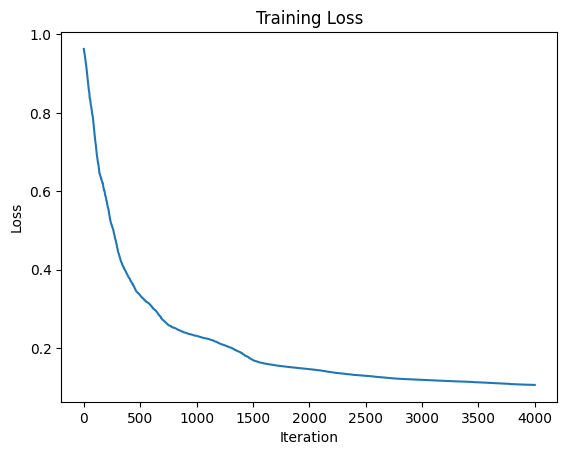

In [18]:
net = Network([20, 16, 1], cost=QuadraticCost, func=Tanh)
n = ringnorm_y_train.size
k = n//10

initial_eta = 0.08
decay_rate = 0.96
decay_step = 100
decay = 0.001

iterations = 0
losses = []
previous_loss = 0
iteration_time = []
# np.random.seed(42)
while True:
    time1 = time.process_time()
    random_seed = random.randint(0, n)
    np.random.seed(random_seed)
    indices = np.random.choice(n, k, replace=True)
    X_train = ringnorm_X_train[indices]
    y_train = ringnorm_y_train[indices]
    training_inputs = [np.reshape(x, (len(x), 1)) for x in X_train]
    training_results = [np.reshape(y, (1, 1)) for y in y_train]
    training_data = list(zip(training_inputs, training_results))

    eta = initial_eta / (1 + decay * iterations)
    # eta = initial_eta * decay_rate ** (iterations / decay_step)
    net.train(training_data, 1, eta)
    # net.train(training_data, 1, eta)
    temp = Network.loss(net, ringnorm_training_data)
    losses.append(temp)
    # if abs(temp - previous_loss) < 1e-7 or iterations == 8000:
    #     break
    if(iterations == 4000):
       break
    previous_loss = temp
    iterations += 1
    time2 = time.process_time()
    iteration_time.append(time2 - time1)

print("Number of iterations: ", iterations)
print("Average iteration time: ", np.mean(iteration_time))
print("Total time: ", np.sum(iteration_time))
print(net.test(ringnorm_test_data))
plt.figure()
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

Number of iterations:  3000
Average iteration time:  0.007520833333333333
Total time:  22.5625
0.778


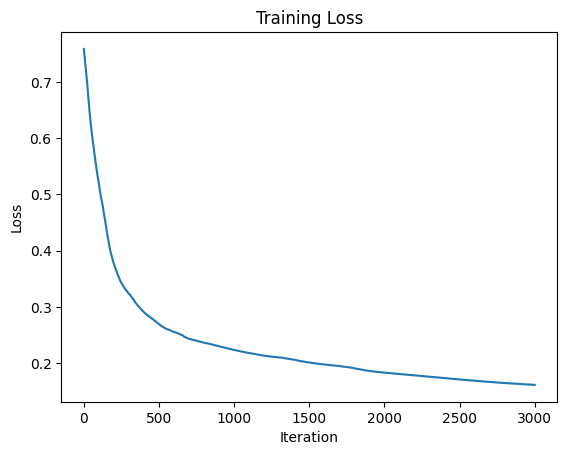

In [24]:
net = Network([20, 16, 1], cost=QuadraticCost, func=Tanh)
n = ringnorm_y_train.size
k = n//5

initial_eta = 0.08
decay_rate = 0.96
decay_step = 100
decay = 0.001

iterations = 0
losses = []
previous_loss = 0
iteration_time = []
# np.random.seed(42)
while True:
    time1 = time.process_time()
    random_seed = random.randint(0, n)
    np.random.seed(random_seed)
    indices = np.random.choice(n, k, replace=True)
    X_train = ringnorm_X_train[indices]
    y_train = ringnorm_y_train[indices]
    training_inputs = [np.reshape(x, (len(x), 1)) for x in X_train]
    training_results = [np.reshape(y, (1, 1)) for y in y_train]
    training_data = list(zip(training_inputs, training_results))

    eta = initial_eta / (1 + decay * iterations)
    # eta = initial_eta * decay_rate ** (iterations / decay_step)
    net.train(training_data, 1, eta)
    # net.train(training_data, 1, eta)
    temp = Network.loss(net, ringnorm_training_data)
    losses.append(temp)
    # if abs(temp - previous_loss) < 1e-7 or iterations == 8000:
    #     break
    if(iterations == 3000):
       break
    previous_loss = temp
    iterations += 1
    time2 = time.process_time()
    iteration_time.append(time2 - time1)

print("Number of iterations: ", iterations)
print("Average iteration time: ", np.mean(iteration_time))
print("Total time: ", np.sum(iteration_time))
print(net.test(ringnorm_test_data))
plt.figure()
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

Number of iterations:  2000
Average iteration time:  0.0101875
Total time:  20.375
0.7878571428571428


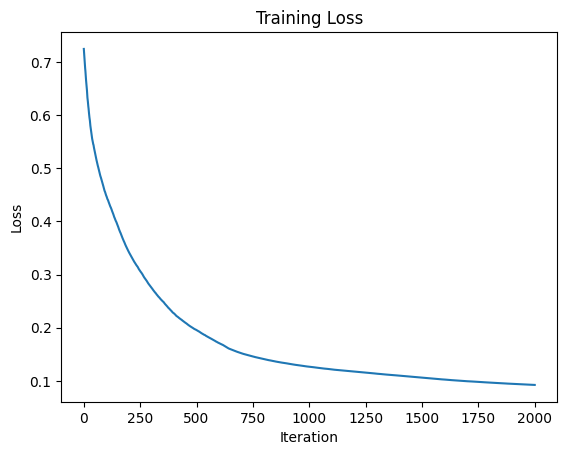

In [25]:
net = Network([20, 16, 1], cost=QuadraticCost, func=Tanh)
n = ringnorm_y_train.size
k = n//2

initial_eta = 0.08
decay_rate = 0.96
decay_step = 100
decay = 0.001

iterations = 0
losses = []
previous_loss = 0
iteration_time = []
# np.random.seed(42)
while True:
    time1 = time.process_time()
    random_seed = random.randint(0, n)
    np.random.seed(random_seed)
    indices = np.random.choice(n, k, replace=True)
    X_train = ringnorm_X_train[indices]
    y_train = ringnorm_y_train[indices]
    training_inputs = [np.reshape(x, (len(x), 1)) for x in X_train]
    training_results = [np.reshape(y, (1, 1)) for y in y_train]
    training_data = list(zip(training_inputs, training_results))

    eta = initial_eta / (1 + decay * iterations)
    # eta = initial_eta * decay_rate ** (iterations / decay_step)
    net.train(training_data, 1, eta)
    # net.train(training_data, 1, eta)
    temp = Network.loss(net, ringnorm_training_data)
    losses.append(temp)
    # if abs(temp - previous_loss) < 1e-7 or iterations == 8000:
    #     break
    if(iterations == 2000):
       break
    previous_loss = temp
    iterations += 1
    time2 = time.process_time()
    iteration_time.append(time2 - time1)

print("Number of iterations: ", iterations)
print("Average iteration time: ", np.mean(iteration_time))
print("Total time: ", np.sum(iteration_time))
print(net.test(ringnorm_test_data))
plt.figure()
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()